# Facial-Expression-Recognition
### Hecho por: Joshua Sancho, Steven Solís y Leonardo Bolaños

## Importar Librerías

In [1]:
import os
import random
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg  
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_visible_devices(physical_devices[0], 'GPU')

## Carga del Dataset

In [2]:
train_dir = "datasets/fer/train" # Directory containing the training data
test_dir = "datasets/fer/test"  # Directory containing the validation data

In [3]:
train_datagen = ImageDataGenerator(
    width_shift_range = 0.1,        # Randomly shift the width of images by up to 10%
    height_shift_range = 0.1,       # Randomly shift the height of images by up to 10%
    horizontal_flip = True,         # Flip images horizontally at random
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

validation_datagen = ImageDataGenerator(
    rescale = 1./255,               # Rescale pixel values to be between 0 and 1
    validation_split = 0.2          # Set aside 20% of the data for validation
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory = train_dir,           # Directory containing the training data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 6 categories
    subset = "training"              # Uses the training subset of the data
)

validation_generator = validation_datagen.flow_from_directory(
    directory = test_dir,            # Directory containing the validation data
    target_size = (48, 48),          # Resizes all images to 48x48 pixels
    batch_size = 64,                 # Number of images per batch
    color_mode = "grayscale",        # Converts the images to grayscale
    class_mode = "categorical",      # Classifies the images into 7 categories
    subset = "validation"            # Uses the validation subset of the data
)

Found 22679 images belonging to 6 classes.
Found 1415 images belonging to 6 classes.


## Visualización de los Datos

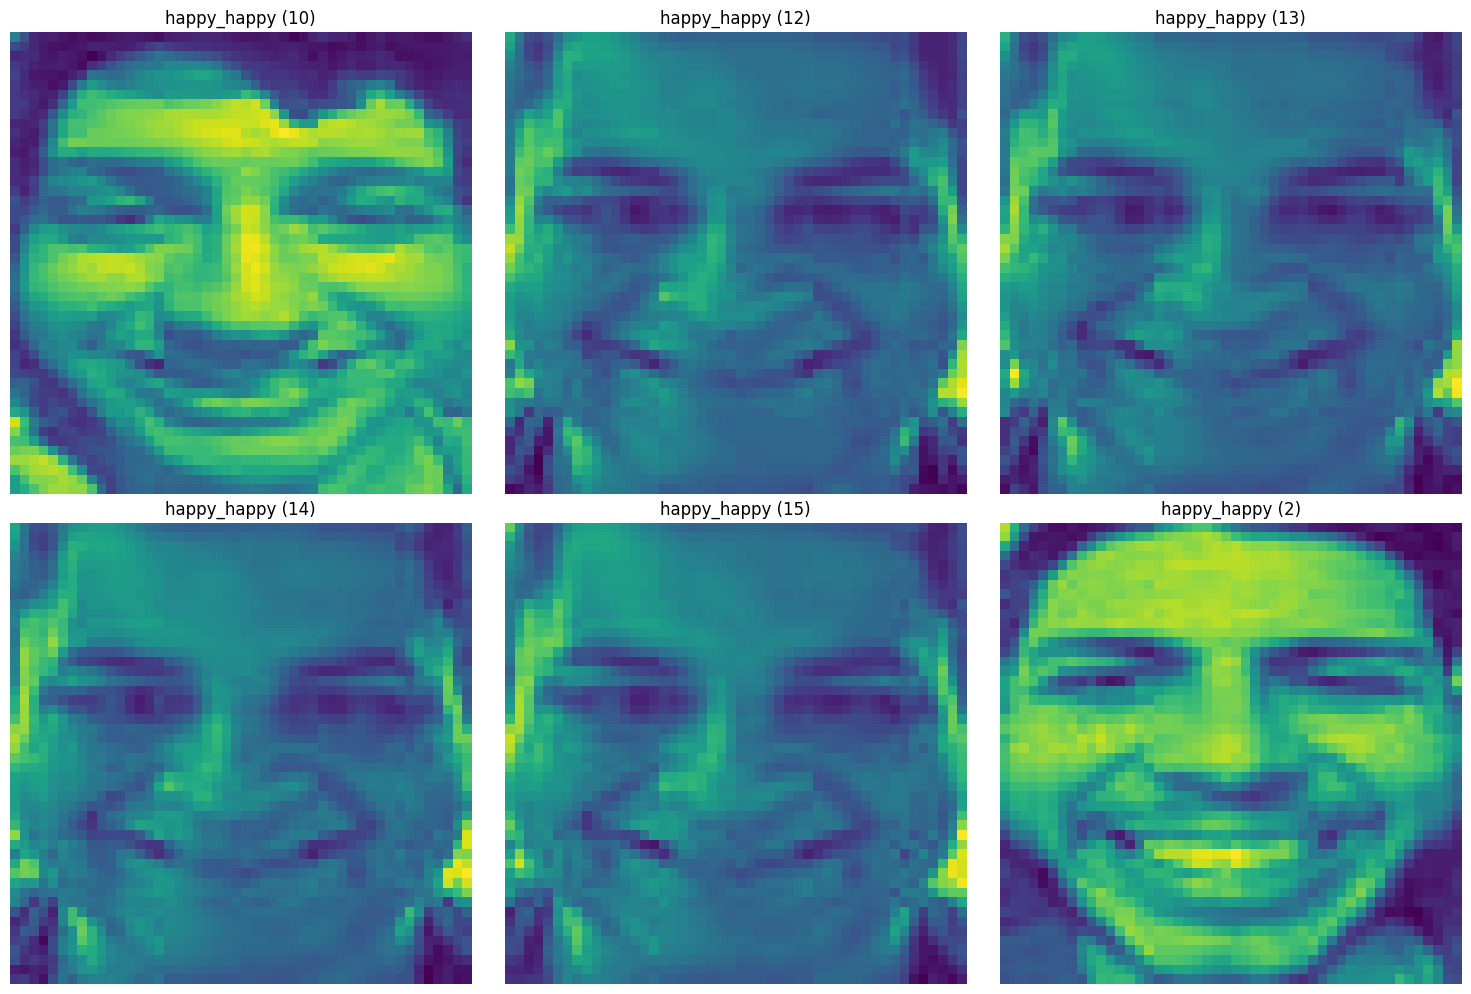

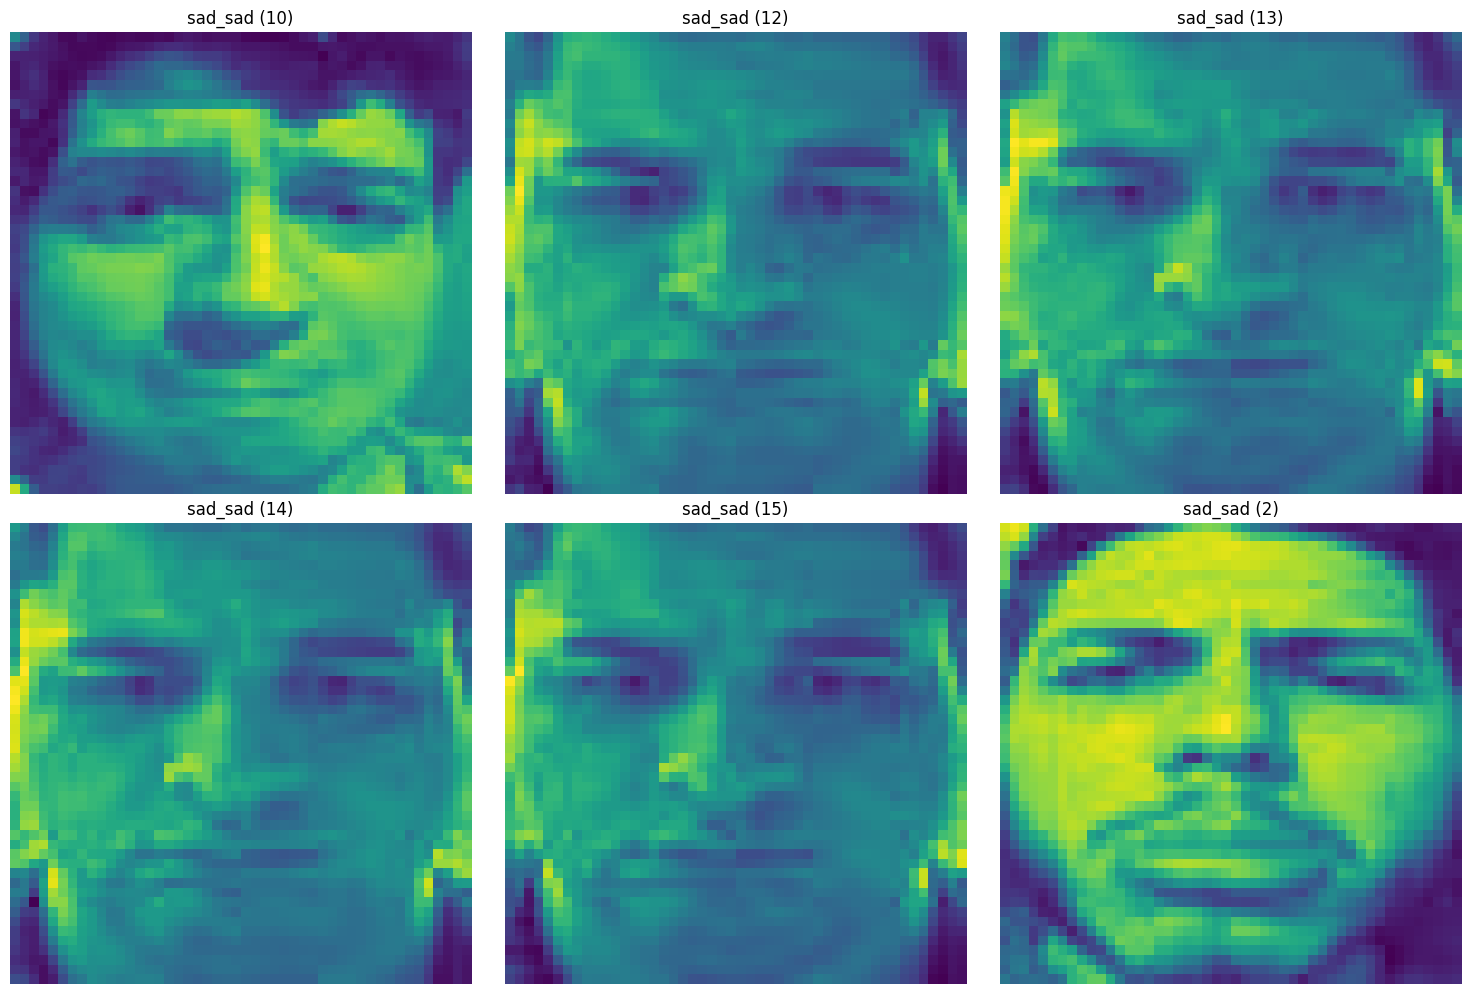

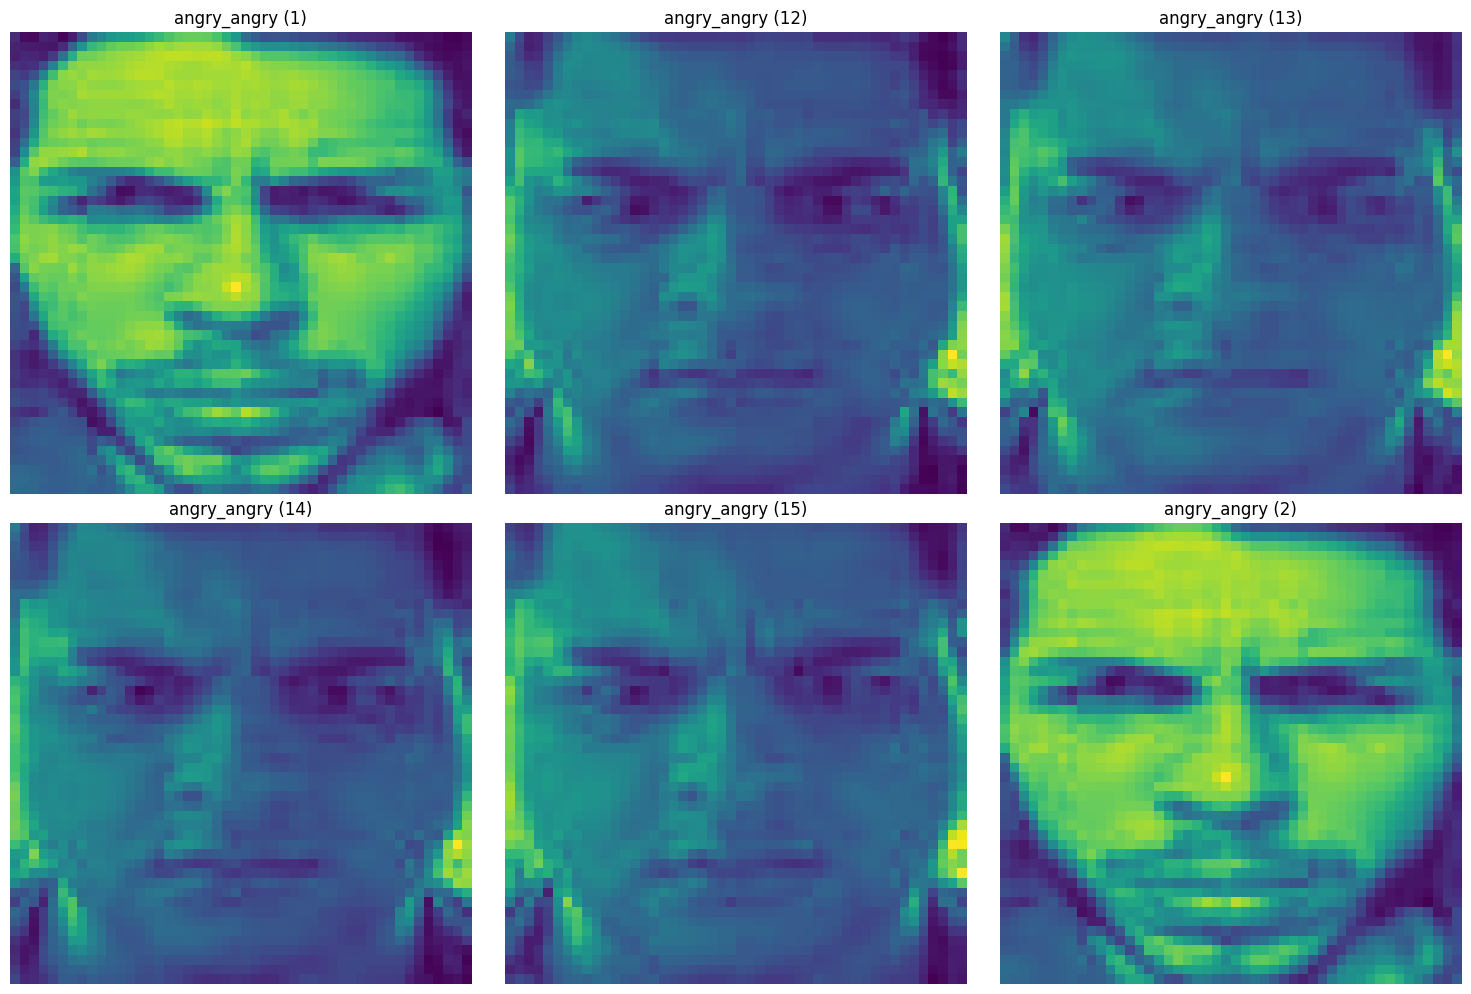

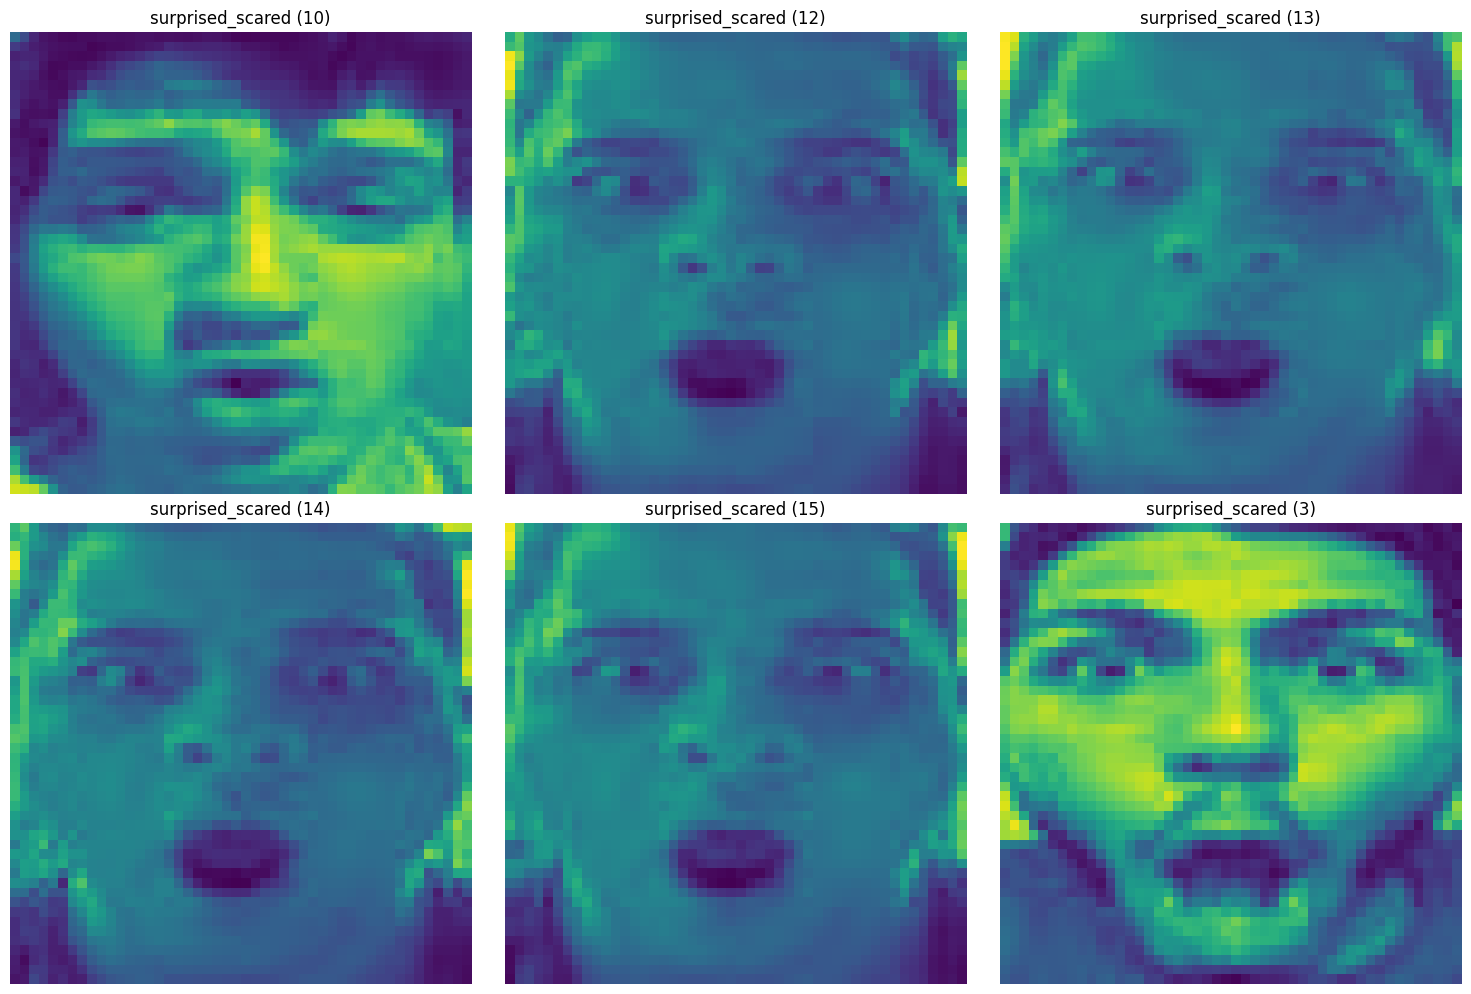

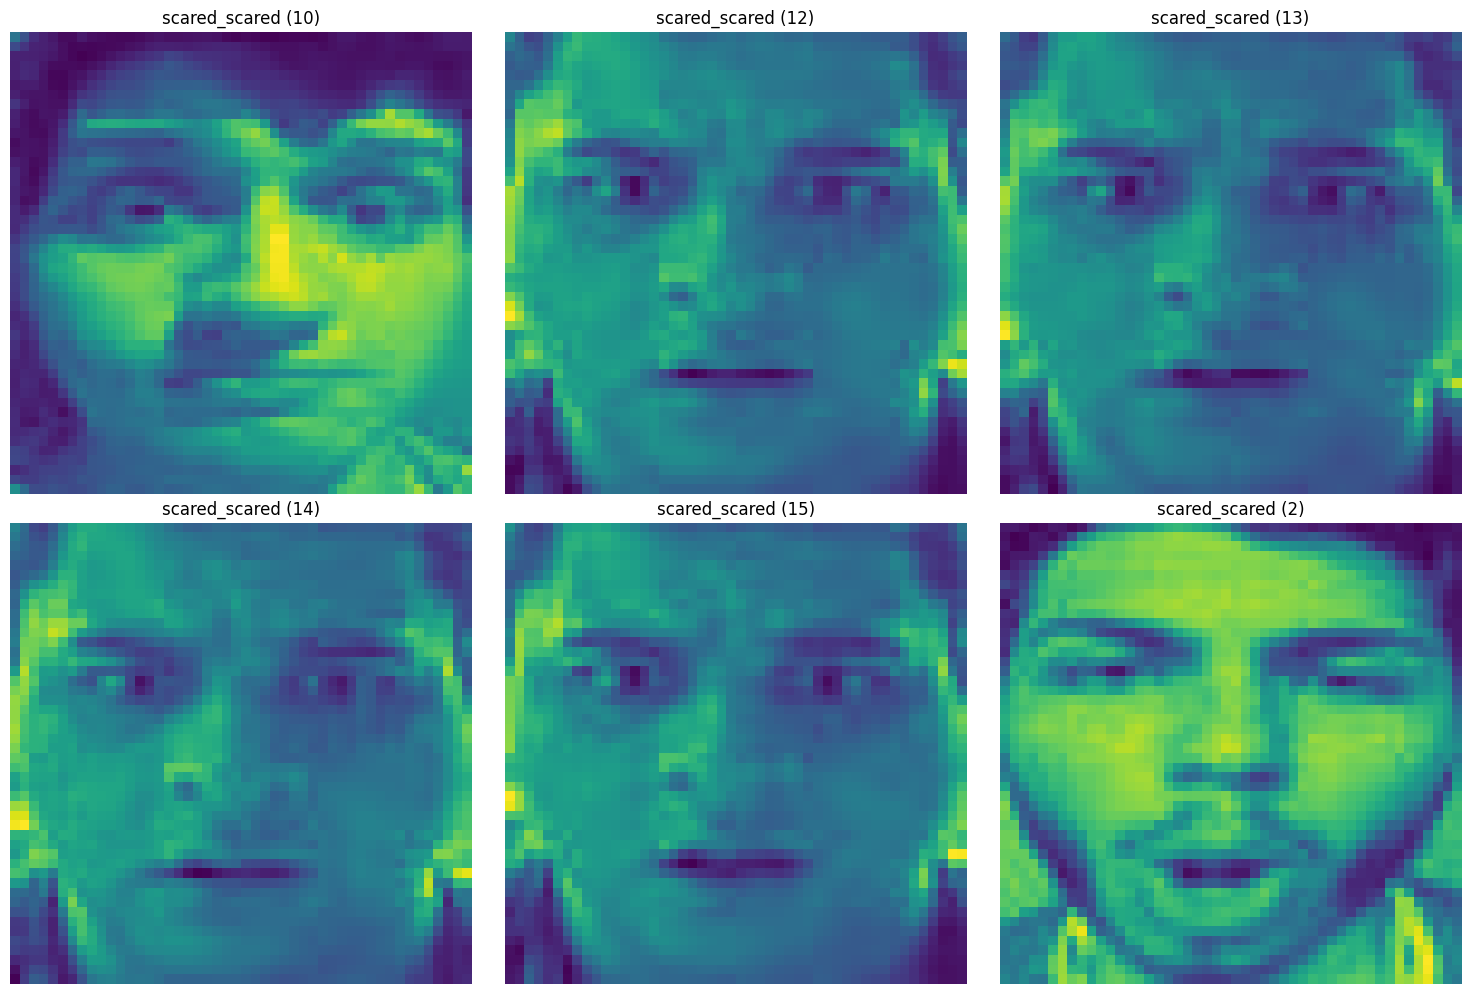

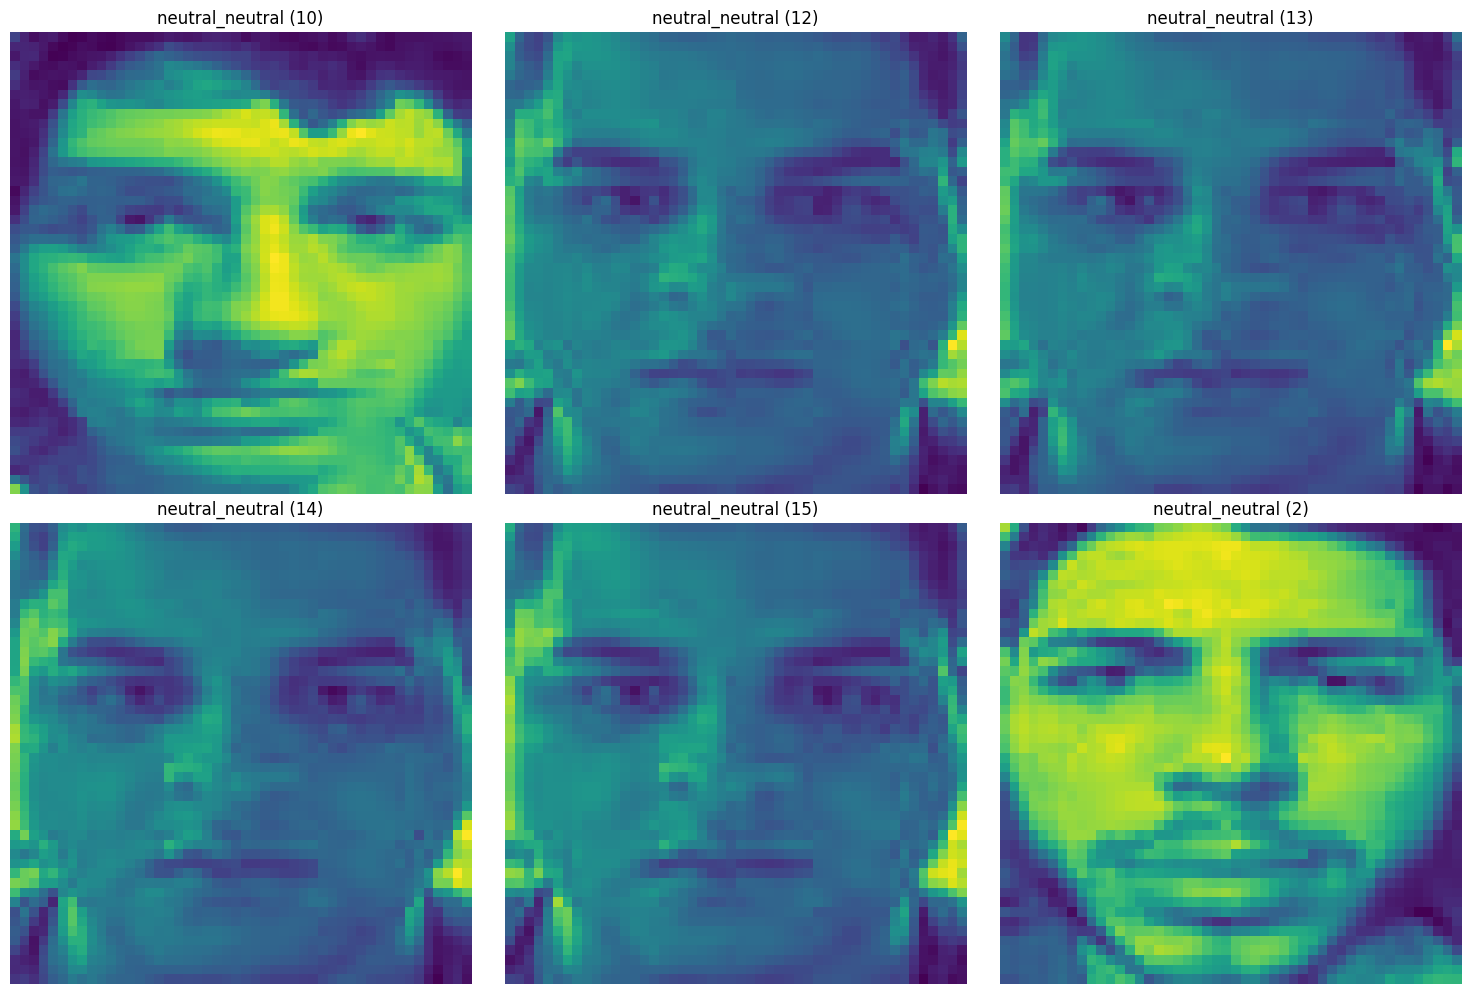

In [5]:
def plot_images(path):
    # Get a list of all image file names in the directory
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

    # Display the first 6 images with their labels
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    for i in range(min(6, len(image_files))):
        # Get the image file name and its label
        image_file = image_files[i]
        label = image_file.split('.')[0]

        # Load and display the image
        img_path = os.path.join(path, image_file)
        img = mpimg.imread(img_path)
        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(label)

    plt.tight_layout()
    plt.show()

plot_images(r"datasets/fer/train/happy")
plot_images(r"datasets/fer/train/sad")
plot_images(r"datasets/fer/train/angry")
plot_images(r"datasets/fer/train/surprise")
plot_images(r"datasets/fer/train/fear")
plot_images(r"datasets/fer/train/neutral")

## Modelo de Deep Learning CNN

In [6]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf 

# Define the model architecture
model = Sequential()

# Add a convolutional layer with 32 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
# Add a batch normalization layer
model.add(BatchNormalization())
# Add a second convolutional layer with 64 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
# Add a second batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a third convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a third batch normalization layer
model.add(BatchNormalization())
# Add a fourth convolutional layer with 128 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
# Add a fourth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Add a fifth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a fifth batch normalization layer
model.add(BatchNormalization())
# Add a sixth convolutional layer with 256 filters, 3x3 kernel size, and relu activation function
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
# Add a sixth batch normalization layer
model.add(BatchNormalization())
# Add a max pooling layer with 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add a dropout layer with 0.25 dropout rate
model.add(Dropout(0.25))

# Flatten the output of the convolutional layers
model.add(Flatten())
# Add a dense layer with 256 neurons and relu activation function
model.add(Dense(256, activation='relu'))
# Add a seventh batch normalization layer
model.add(BatchNormalization())
# Add a dropout layer with 0.5 dropout rate
model.add(Dropout(0.5))
# Add a dense layer with 7 neurons (one for each class) and softmax activation function
model.add(Dense(6, activation='softmax'))

# Compile the model with categorical cross-entropy loss, adam optimizer, and accuracy metric
model.compile(loss="categorical_crossentropy", optimizer= tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

## Entrenamiento del Modelo

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callback for early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=15,              # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights to the best observed during training
)

# Define the callback for model checkpointing
checkpoint_callback = ModelCheckpoint(
    filepath='fer.keras',  # Path to save the model weights
    monitor='val_accuracy',       # Monitor validation accuracy
    save_best_only=True,          # Save only the best model
    save_weights_only=False,       # Save only the model weights
    mode='max',                   # Save the model with the highest validation accuracy
    verbose=1                     # Verbosity mode, 1 for displaying messages
)

# Train the model with both callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=200,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping, checkpoint_callback]  # Include both callbacks
)

Epoch 1/200
354/355 [============================>.] - ETA: 0s - loss: 2.5892 - accuracy: 0.2086
Epoch 1: val_accuracy improved from -inf to 0.23746, saving model to fer.keras
355/355 [==============================] - 15s 34ms/step - loss: 2.5888 - accuracy: 0.2087 - val_loss: 1.8505 - val_accuracy: 0.2375
Epoch 2/200
354/355 [============================>.] - ETA: 0s - loss: 2.2754 - accuracy: 0.2403
Epoch 2: val_accuracy improved from 0.23746 to 0.33216, saving model to fer.keras
355/355 [==============================] - 12s 33ms/step - loss: 2.2758 - accuracy: 0.2401 - val_loss: 1.6606 - val_accuracy: 0.3322
Epoch 3/200
354/355 [============================>.] - ETA: 0s - loss: 2.0898 - accuracy: 0.2777
Epoch 3: val_accuracy improved from 0.33216 to 0.34770, saving model to fer.keras
355/355 [==============================] - 11s 32ms/step - loss: 2.0897 - accuracy: 0.2775 - val_loss: 1.6802 - val_accuracy: 0.3477
Epoch 4/200
354/355 [============================>.] - ETA: 0s - lo

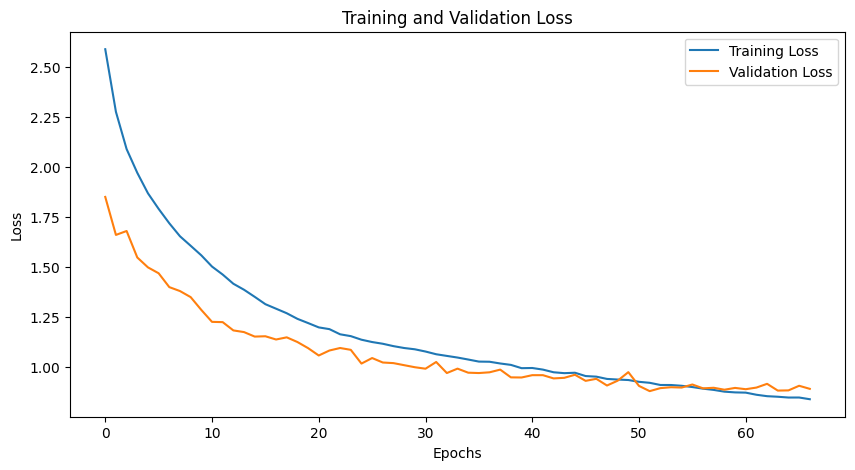

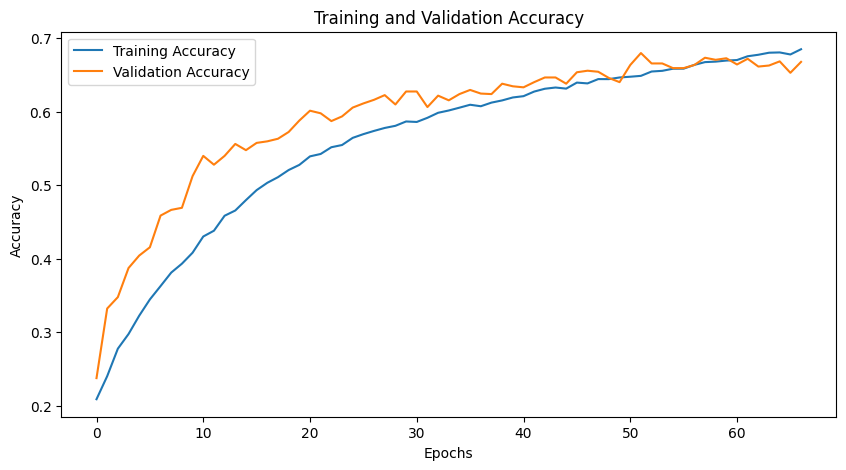

In [8]:
# Get training history
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

# Get validation history
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

23/23 [==============================] - 0s 16ms/step


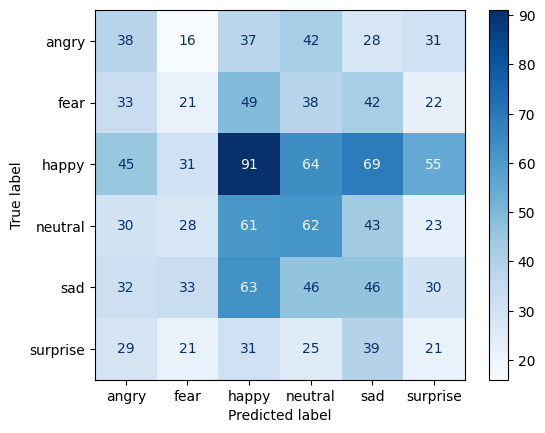

In [15]:
# Make predictions on the validation dataset
y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes

# Get class labels
class_labels = list(validation_generator.class_indices.keys())

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()